Primary goal is to define a function by which we give it a file name and mass threshold and the entirety of the calculation in terms of CFs, MCFs, and various cuts are output as a single data vector. We will start by assuming a value of fname and mthresh and go from there, and see what needs changing.

In [1]:
# required imports for the function here
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import halotools.mock_observables as mo
import halotools.sim_manager as sm


In [46]:
fname = './l0250_d200b.catalog' # file name to z0.0.catalog
mthresh = 7e11  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 250
nbins = 50

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8'),
           'halo_cnfw':(11,'f8'), 'halo_vratio':(12,'f8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data = reader.read_ascii()

# add vratio mark
vratio_temp = hosts_data['halo_vmax']/(np.sqrt(gnewton * hosts_data['halo_mass']/hosts_data['halo_rvir']))
hosts_data['halo_vratio'] = vratio_temp
cnfw_temp = hosts_data['halo_rvir']/hosts_data['halo_rs']
hosts_data['halo_cnfw'] = cnfw_temp

# now that we have data, we need to mass correct all of our marks
mass_sort = np.sort(hosts_data, order='halo_mass')

vratio_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), 
                                       np.log10(mass_sort['halo_vratio']),
                                       statistic='mean', bins=nbins)
vratio_fix_log = np.log10(mass_sort['halo_vratio']) - vratio_binned.statistic[vratio_binned.binnumber-1]
vratio_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                      mass_sort['halo_vratio'], statistic='mean', bins=nbins)
vratio_fix = mass_sort['halo_vratio'] / vratio_binned.statistic[vratio_binned.binnumber-1]
vratio_fix_alt = mass_sort['halo_vratio']-vratio_binned.statistic[vratio_binned.binnumber-1]

cnfw_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), 
                                     np.log10(mass_sort['halo_cnfw']),
                                     statistic = 'mean', bins=nbins)
cnfw_fix_log = np.log10(mass_sort['halo_cnfw']) - cnfw_binned.statistic[cnfw_binned.binnumber-1]
cnfw_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), mass_sort['halo_cnfw'], statistic='mean',
                                     bins = nbins)
cnfw_fix = mass_sort['halo_cnfw'] / cnfw_binned.statistic[cnfw_binned.binnumber-1]
cnfw_fix_alt = mass_sort['halo_cnfw'] - cnfw_binned.statistic[cnfw_binned.binnumber-1]

shape_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), 
                                      np.log10(mass_sort['halo_ctoa']),
                                      statistic='mean', bins=nbins)
shape_fix_log = np.log10(mass_sort['halo_ctoa']) - shape_binned.statistic[shape_binned.binnumber-1]
shape_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                     mass_sort['halo_ctoa'], statistic='mean', bins=nbins)
shape_fix = mass_sort['halo_ctoa'] / shape_binned.statistic[shape_binned.binnumber-1]
shape_fix_alt = mass_sort['halo_ctoa'] - shape_binned.statistic[shape_binned.binnumber-1]

spin_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), 
                                     np.log10(mass_sort['halo_spin']),
                                     statistic='mean', bins=nbins)
spin_fix_log = (mass_sort['halo_spin']) - spin_binned.statistic[spin_binned.binnumber-1]
spin_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']), mass_sort['halo_spin'],
                                    statistic='mean', bins=nbins)
spin_fix = mass_sort['halo_spin'] / spin_binned.statistic[spin_binned.binnumber-1]
spin_fix_alt = mass_sort['halo_spin'] - spin_binned.statistic[spin_binned.binnumber-1]


...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0250_d200b.catalog
 
Total number of rows in detected data = 2342337
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 15.39 seconds




In [61]:
# this SHOULD allow us to move everything into the main section without having to overwrite existing blocks. So we can
# thus strip out some of the data that is read in just to be written over in favor of just adding in new columns.
# Hurray!
from numpy.lib.recfunctions import append_fields
new_sort = append_fields(mass_sort, ('halo_spin_fix', 'halo_shape_fix'), (spin_fix, shape_fix))

In [64]:
np.zeros(len(new_sort))

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

-2.15254659623e-16
0.20513387362
-1.14041343816


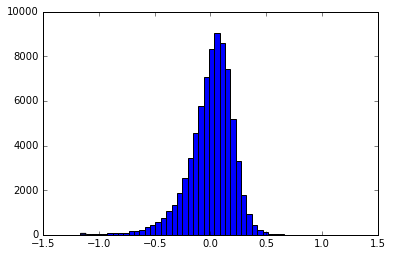

In [47]:
plt.hist(cnfw_fix_log, color='blue',bins=50)
print np.mean(cnfw_fix_log)
print np.std(cnfw_fix_log)
print stats.skew(cnfw_fix_log)

1.0
0.425571181476
2.14470374389


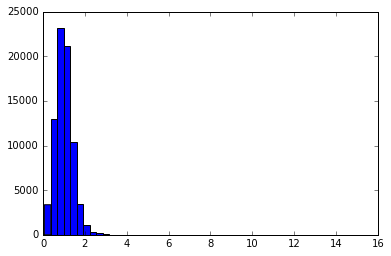

In [48]:
plt.hist(cnfw_fix, color='blue', bins=50)
print np.mean(cnfw_fix)
print np.std(cnfw_fix)
print stats.skew(cnfw_fix)

-8.26297909616e-15
6.01947317842
2.27573992188


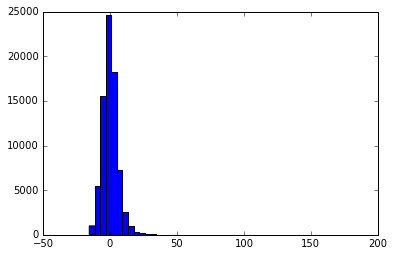

In [49]:
plt.hist(cnfw_fix_alt, color='blue', bins=50)
print np.mean(cnfw_fix_alt)
print np.std(cnfw_fix_alt)
print stats.skew(cnfw_fix_alt)

240.88221957
1.1811108305
1.60993944635


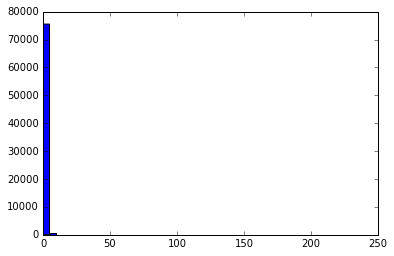

In [50]:
plt.hist(cnfw_fix**2, color='blue', bins=50)
print np.max(cnfw_fix**2)
print np.mean(cnfw_fix**2)
print np.std(cnfw_fix**2)

240.88221957
0.0420799061062
0.0964209779356


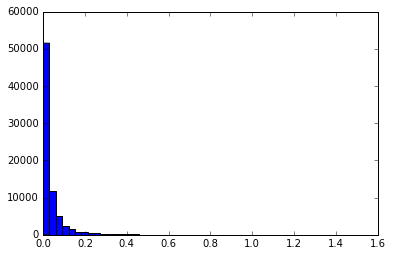

In [51]:
plt.hist(cnfw_fix_log**2, color='blue', bins=50)
print np.max(cnfw_fix**2)
print np.mean(cnfw_fix_log**2)
print np.std(cnfw_fix_log**2)